# Analysis of State of the State (SoS) Addresses

In [1]:
# set up 
import csv
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import re 
from sklearn.decomposition import PCA
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

%xmode Minimal

Exception reporting mode: Minimal


In [103]:
# read in data 
sos = pd.read_csv('../../sos_df_23_revised.csv')

In [104]:
# explore data
sos.info()
sos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   state     50 non-null     object
 1   gov_name  50 non-null     object
 2   party     50 non-null     object
 3   type      50 non-null     object
 4   text      50 non-null     object
dtypes: object(5)
memory usage: 2.1+ KB


,state,gov_name,party,type,text
0,alabama,kay ivey,republican,sos,Page 1 of 8 2023 STATE OF THE STATE ADDRES...
1,alaska,mike dunleavy,republican,sos,Governor Dunleavy’s 2023 State of the State Ad...
2,arizona,katie hobbs,democratic,sos,"Good afternoon, Chief Justice Brutinel, Secret..."
3,arkansas,sarah huckabee sanders,republican,inaug,"LITTLE ROCK, Ark.— Today, Governor Sarah Hucka..."
4,california,gavin newsom,democratic,inaug,Watch Governor Newsom’s swearing-in and inaugu...


## Explore all State of the State addresses

### Create Term Frequency - Inverse Document Frequency (TF-IDF) matrix

In [105]:
# add estimated word count columm 
sos['word_count'] = [len(i.split()) for i in sos.text]

In [106]:
# check that this worked
sos 

,state,gov_name,party,type,text,word_count
0,alabama,kay ivey,republican,sos,Page 1 of 8 2023 STATE OF THE STATE ADDRES...,2980
1,alaska,mike dunleavy,republican,sos,Governor Dunleavy’s 2023 State of the State Ad...,6469
2,arizona,katie hobbs,democratic,sos,"Good afternoon, Chief Justice Brutinel, Secret...",4882
3,arkansas,sarah huckabee sanders,republican,inaug,"LITTLE ROCK, Ark.— Today, Governor Sarah Hucka...",2250
4,california,gavin newsom,democratic,inaug,Watch Governor Newsom’s swearing-in and inaugu...,2456
5,colorado,jared polis,democratic,sos,ForMedia-2023-StateOfState-GovernorPolis-AsPre...,7859
6,connecticut,ned lamont,democratic,sos,\r\n01/03/2023 2023 State of the ...,1878
7,delaware,john carney,democratic,sos,"January 19, 2023 As prepared for delivery #DE...",4157
8,florida,ron desantis,republican,sos,"From the Space Coast to the Suncoast, from St....",1658
9,georgia,brian kemp,republican,sos,"Lt. Governor Jones, Speaker Burns, President P...",3315


#### Examine distribution of word count and outiers

In [107]:
sos.word_count.describe()

count       50.000000
mean      5136.580000
std       5216.723446
min        531.000000
25%       3286.250000
50%       4251.500000
75%       4970.500000
max      36640.000000
Name: word_count, dtype: float64

(array([ 1.,  3.,  3., 10.,  5., 13.,  4.,  4.,  3.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  531.  ,  1253.18,  1975.36,  2697.54,  3419.72,  4141.9 ,
         4864.08,  5586.26,  6308.44,  7030.62,  7752.8 ,  8474.98,
         9197.16,  9919.34, 10641.52, 11363.7 , 12085.88, 12808.06,
        13530.24, 14252.42, 14974.6 , 15696.78, 16418.96, 17141.14,
        17863.32, 18585.5 , 19307.68, 20029.86, 20752.04, 21474.22,
        22196.4 , 22918.58, 23640.76, 24362.94, 25085.12, 25807.3 ,
        26529.48, 27251.66, 27973.84, 28696.02, 29418.2 , 30140.38,
        30862.56, 31584.74, 32306.92, 33029.1 , 33751.28, 34473.46,
        35195.64, 35917.82, 36640.  ]),
 <BarContainer object of 50 artists>)

Text(6100, 5, 'Mean length: 5136 words')

Text(6100, 7, 'Median length: 4251 words')

Text(0.5, 1.0, 'From 50 State of the State Addresses for 2023')

Text(0.5, 0.98, 'Distribution of Document Length - SOS')

Text(0.5, 0, 'Document Word Count')

Text(0, 0.5, 'Number of Documents')

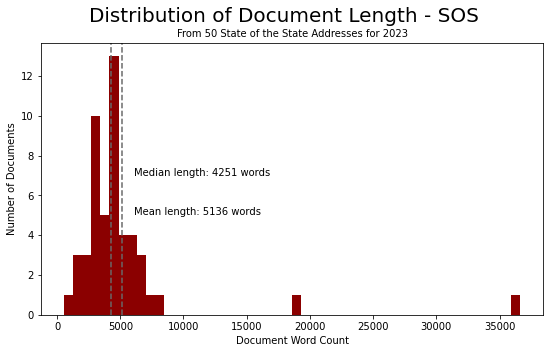

In [108]:
# plot the distribution 
fig, ax = plt.subplots(figsize=(9,5))
ax.hist(sos.word_count, bins = 50, color = 'darkred')
ax.text(6100, 5, 'Mean length: 5136 words')
plt.axvline(x = 5136, color = 'dimgrey',ls = 'dashed')
ax.text(6100, 7, 'Median length: 4251 words')
plt.axvline(x = 4251, color = 'dimgrey',ls = 'dashed')
plt.title('From 50 State of the State Addresses for 2023', size = 10)
plt.suptitle('Distribution of Document Length - SOS', size = 20)
plt.xlabel('Document Word Count')
plt.ylabel('Number of Documents')

In [109]:
# check the outliers
outliers = sos[sos.word_count > 15000].reset_index(drop = True)
outliers

,state,gov_name,party,type,text,word_count
0,illinois,jb pritzker,democratic,sos,"Gov. Pritzker Proposes Transformative, Gener...",18781
1,west virginia,jim justice,republican,sos,VIEW PHOTO ALBUM ...,36640


In [112]:
# duplicates 
# looks like text is repeated so let's clean
# outliers.text[0]

In [110]:
# test cleaning method
pattern = r'God bless the great state of Illinois'
input_string = outliers.text[0]
match = re.search(pattern, input_string)
clean_string = input_string[:match.end()]

# clean_string

In [11]:
# same issue of repeated text
# outliers.text[1]

In [12]:
# test cleaning method for second example
pattern2 = r'Thank you so much for having me. And God bless all of you.'

input_string2 = outliers.text[1]

match2 = re.search(pattern2, input_string2)

clean_string2 = input_string2[:match2.end()]

# clean_string2 

In [114]:
# do in main df 
def replace_text(state, pattern):
    input_string = sos.loc[sos.state == state, 'text'].values[0]
    match = re.search(pattern, input_string)
    clean_string = input_string[:match.end()]
    sos.loc[sos.state == state, 'text'] = clean_string
    return f'successfully added cleaned text for {state}'

In [115]:
replace_text('illinois', r'God bless the great state of Illinois')

'successfully added cleaned text for illinois'

In [116]:
replace_text('west virginia', r'Thank you so much for having me. And God bless all of you.')

'successfully added cleaned text for west virginia'

In [117]:
# redo word count 
sos['new_word_count'] = [len(i.split()) for i in sos.text]

In [118]:
sos.word_count.describe()
sos.new_word_count.describe() 

count       50.000000
mean      5136.580000
std       5216.723446
min        531.000000
25%       3286.250000
50%       4251.500000
75%       4970.500000
max      36640.000000
Name: word_count, dtype: float64

count      50.000000
mean     4337.100000
std      1692.697669
min       531.000000
25%      3286.250000
50%      4251.500000
75%      4970.500000
max      9157.000000
Name: new_word_count, dtype: float64

(array([ 1.,  1.,  3.,  3.,  9.,  2., 11.,  8.,  2.,  3.,  4.,  0.,  2.,
         0.,  1.]),
 array([ 531.        , 1106.06666667, 1681.13333333, 2256.2       ,
        2831.26666667, 3406.33333333, 3981.4       , 4556.46666667,
        5131.53333333, 5706.6       , 6281.66666667, 6856.73333333,
        7431.8       , 8006.86666667, 8581.93333333, 9157.        ]),
 <BarContainer object of 15 artists>)

Text(6000, 6, 'Mean length: 4337 words')

Text(0.5, 1.0, 'From 50 State of the State Addresses for 2023')

Text(0.5, 0.98, 'Distribution of Document Length - SOS')

Text(0.5, 0, 'Document Word Count')

Text(0, 0.5, 'Number of Documents')

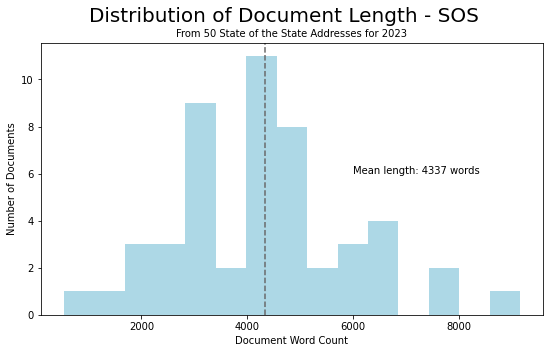

In [119]:
fig, ax = plt.subplots(figsize=(9,5))
ax.hist(sos.new_word_count, bins = 15, color = 'lightblue')
ax.text(6000, 6, 'Mean length: 4337 words')
plt.axvline(x = 4337, color = 'dimgrey',ls = 'dashed')
plt.title('From 50 State of the State Addresses for 2023', size = 10)
plt.suptitle('Distribution of Document Length - SOS', size = 20)
plt.xlabel('Document Word Count')
plt.ylabel('Number of Documents') 

#### Min doc frequency 

In [120]:
# explore minimum document frequency options of 1-30
term_count = []

for i in range(1, 31):
    vectorizer = CountVectorizer(stop_words='english', min_df=i)
    dtm = vectorizer.fit_transform(sos.text)
    length = dtm.shape[1]
    term_count.append(length)

min_df = pd.DataFrame(data = {'Min Doc': range(1,31),
                              'Term Count': term_count})

Text(0.5, 1.0, 'From 50 State of the State Addresses in 2023')

Text(0.5, 0.98, 'Minimum Document Frequency and Resulting Term Count')

Text(0, 0.5, 'Term Count')

Text(0.5, 0, 'Minimum Document Frequency')

([<matplotlib.axis.XTick at 0x7f8b136dca60>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30')])

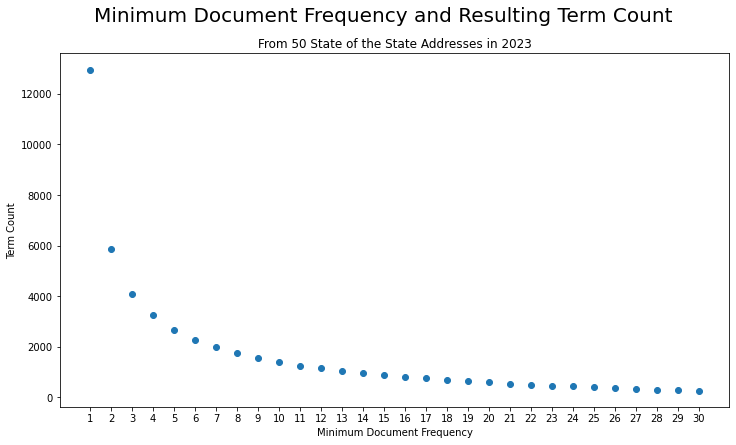

In [121]:
fig, ax = plt.subplots(figsize=(12,6.5))
# ax.plot(range(1,26), min_df['Term Count'], linewidth = 2.5, color = 'green')
ax.scatter(x = min_df['Min Doc'], y = min_df['Term Count'])
plt.title('From 50 State of the State Addresses in 2023')
plt.suptitle('Minimum Document Frequency and Resulting Term Count', size = 20)
plt.ylabel('Term Count')
plt.xlabel('Minimum Document Frequency')
plt.xticks(range(1,31))
#plt.savefig('min_doc_freq.png')

In [122]:
# Let's use 6 to reduce the words but still keep a high term count. Plus our overall sample size (50) is low.

#### + custom stopwords

In [123]:
# define functions for testing hyper parameter easily
def convert_to_term_df(dtm_input, tfidf_vectorizer_input):
    content_index = pd.DataFrame(dtm_input.toarray()).head()
    term_indices = {index: term for term, index in tfidf_vectorizer_input.vocabulary_.items()}
    colterms = [term_indices[i] for i in range(dtm_input.shape[1])]
    final_df = pd.DataFrame(dtm_input.toarray(), columns=colterms)

    return final_df

In [23]:
# define function to print the top most frequent terms in the tf-idf
# https://stackoverflow.com/questions/34232190/scikit-learn-tfidfvectorizer-how-to-get-top-n-terms-with-highest-tf-idf-score
def get_top_terms(dtm_input, tfidf_vectorizer_input, num):
    importance = np.argsort(np.asarray(dtm_input.sum(axis=0)).ravel())[::-1]
    tfidf_feature_names = np.array(tfidf_vectorizer_input.get_feature_names_out())
    return tfidf_feature_names[importance[: num]]

In [140]:
# vectorize with stop words only 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=6)
dtm = tfidf_vectorizer.fit_transform(sos.text)
dtm.shape #(50, 2267)

(50, 2267)

In [125]:
# create df
df = convert_to_term_df(dtm, tfidf_vectorizer)
df.head()

,000,10,100,11,12,120,13,14,15,150,...,years,yes,yesterday,york,young,youngest,youth,zero,zip,zoning
0,0.011607,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.060672,0.000000,0.0,0.0,0.040108,0.027115,0.0,0.000000,0.026071,0.000000
1,0.006296,0.014209,0.015771,0.010980,0.018004,0.0,0.035882,0.011961,0.009662,0.000000,...,0.170035,0.024663,0.0,0.0,0.021756,0.000000,0.0,0.013629,0.000000,0.000000
2,0.031431,0.017733,0.009841,0.000000,0.033704,0.0,0.000000,0.000000,0.012058,0.013703,...,0.061608,0.000000,0.0,0.0,0.009050,0.000000,0.0,0.000000,0.000000,0.000000
3,0.016376,0.000000,0.000000,0.028558,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.085597,0.000000,0.0,0.0,0.018862,0.076509,0.0,0.000000,0.036781,0.000000
4,0.011601,0.013090,0.014529,0.020231,0.000000,0.0,0.000000,0.000000,0.000000,0.020231,...,0.080850,0.045443,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.028267


In [141]:
# add custom stop words - (tweaked throughout the process based on later parts of this notebook)
# https://aparnamishra144.medium.com/how-to-add-custom-stopwords-and-remove-them-from-text-in-nlp-50d342cfafff

stop_list = ['four','absolutely','tonight','state', 'governor', 'year', 'alabama', 'new', 'north', 'south', 'west', 'alaska', 'arizona', 'arkansas', 'california', 'colorado',
             'connecticut','delaware','florida','georgia','hawaii','idaho','illinois','indiana','iowa',
             'kansas','kentucky','louisiana','maine','maryland','massachusetts','michigan','minnesota',
             'mississippi','missouri','montana','nebraska','nevada', 'hampshire', 'jersey', 'mexico','york',
             'carolina', 'dakota','ohio','oklahoma','oregon','pennsylvania','rhode','island','tennessee','texas',
             'utah','vermont','virginia','washington','west virginia', 'wisconsin','wyoming', 
             'could', 'doe', 'ha', 'kansa', 'might', 'must', 'need', 'sha', 'wa', 'would']

stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(stop_list)
#stpwrd

In [142]:
# vectorize with custom stop words only 
tfidf_vectorizer1 = TfidfVectorizer(stop_words=stpwrd, min_df=6)
dtm1 = tfidf_vectorizer1.fit_transform(sos.text)
dtm1.shape # (50, 2348) # increased word count 

(50, 2348)

In [128]:
# get frequent terms 
get_top_terms(dtm1, tfidf_vectorizer1, 10)

# create df
df1 = convert_to_term_df(dtm1, tfidf_vectorizer1)
df1.head()

array(['people', 'us', 'years', 'one', 'every', 'work', 'make', 'also',
       'today', 'first'], dtype=object)

,000,10,100,11,12,120,13,14,15,150,...,years,yes,yesterday,yet,young,youngest,youth,zero,zip,zoning
0,0.011574,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.060497,0.000000,0.0,0.000000,0.039992,0.027037,0.0,0.000000,0.025996,0.000000
1,0.006947,0.015677,0.017400,0.012115,0.019865,0.0,0.039589,0.013196,0.010660,0.000000,...,0.187605,0.027212,0.0,0.000000,0.024004,0.000000,0.0,0.015037,0.000000,0.000000
2,0.032102,0.018112,0.010051,0.000000,0.034424,0.0,0.000000,0.000000,0.012315,0.013996,...,0.062924,0.000000,0.0,0.000000,0.009244,0.000000,0.0,0.000000,0.000000,0.000000
3,0.015874,0.000000,0.000000,0.027682,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.082972,0.000000,0.0,0.041511,0.018283,0.074163,0.0,0.000000,0.035653,0.000000
4,0.015362,0.017334,0.019239,0.026789,0.000000,0.0,0.000000,0.000000,0.000000,0.026789,...,0.107061,0.060175,0.0,0.040172,0.000000,0.000000,0.0,0.000000,0.000000,0.037431


#### + words only

In [129]:
# vectorize with stop words and words only (remove numbers and must be 3 letters minimum)
tfidf_vectorizer2 = TfidfVectorizer(stop_words=stpwrd, min_df=6, token_pattern= r'\b[a-zA-Z]{3,}\b')
dtm2 = tfidf_vectorizer2.fit_transform(sos.text)
dtm2.shape #(50, 2281) # reduced term count again 

(50, 2281)

In [130]:
# get most frequent terms
get_top_terms(dtm2, tfidf_vectorizer2, 10)

# create df
df2 = convert_to_term_df(dtm2, tfidf_vectorizer2)
df2.head()

array(['people', 'years', 'one', 'every', 'work', 'make', 'also', 'first',
       'today', 'let'], dtype=object)

,ability,able,abortion,abroad,abundance,abundant,abuse,academy,accelerate,accept,...,years,yes,yesterday,yet,young,youngest,youth,zero,zip,zoning
0,0.037428,0.013649,0.000000,0.029607,0.029607,0.000000,0.0,0.0,0.025125,0.023469,...,0.060672,0.000000,0.0,0.000000,0.040108,0.027115,0.0,0.000000,0.026071,0.000000
1,0.023001,0.008388,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.100959,...,0.192641,0.027942,0.0,0.000000,0.024648,0.000000,0.0,0.015441,0.000000,0.000000
2,0.000000,0.000000,0.015866,0.000000,0.000000,0.019739,0.0,0.0,0.000000,0.000000,...,0.063514,0.000000,0.0,0.000000,0.009330,0.000000,0.0,0.000000,0.000000,0.000000
3,0.025868,0.000000,0.000000,0.000000,0.000000,0.039096,0.0,0.0,0.000000,0.032441,...,0.083867,0.000000,0.0,0.041959,0.018480,0.074963,0.0,0.000000,0.036037,0.000000
4,0.000000,0.000000,0.030270,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.107710,0.060539,0.0,0.040416,0.000000,0.000000,0.0,0.000000,0.000000,0.037658


#### + bigrams

In [131]:
# vectorize with bigrams (two word pairs)
tfidf_vectorizer3 = TfidfVectorizer(stop_words=stpwrd, min_df=6, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b')
dtm3 = tfidf_vectorizer3.fit_transform(sos.text)
dtm3.shape  # (50, 2826) # bigger increase in term count 

(50, 2826)

In [132]:
# get most frequent terms
get_top_terms(dtm3, tfidf_vectorizer3, 10)

# create df
df3 = convert_to_term_df(dtm3, tfidf_vectorizer3)
df3.head()

array(['people', 'years', 'one', 'every', 'work', 'make', 'first', 'also',
       'today', 'let'], dtype=object)

,ability,able,able get,abortion,abroad,abundance,abundant,abuse,academy,accelerate,...,yesterday,yet,young,young people,youngest,youth,zero,zip,zip code,zoning
0,0.035203,0.012837,0.027848,0.000000,0.027848,0.027848,0.000000,0.0,0.0,0.023632,...,0.0,0.000000,0.037724,0.055605,0.025504,0.0,0.000000,0.024521,0.025504,0.000000
1,0.021873,0.007976,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.023439,0.011516,0.000000,0.0,0.014683,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.015112,0.000000,0.000000,0.018800,0.0,0.0,0.000000,...,0.0,0.000000,0.008887,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.024841,0.000000,0.000000,0.000000,0.000000,0.000000,0.037544,0.0,0.0,0.000000,...,0.0,0.040293,0.017747,0.000000,0.071987,0.0,0.000000,0.034607,0.035993,0.000000
4,0.000000,0.000000,0.000000,0.029520,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.039414,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.036725


#### + maxdf 

In [133]:
tfidf_vectorizer4 = TfidfVectorizer(stop_words=stpwrd, min_df=6, max_df=0.80, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b')
dtm4 = tfidf_vectorizer4.fit_transform(sos.text)
dtm4.shape  # (50, 2722) # removed words

(50, 2722)

In [134]:
# get most frequent terms
get_top_terms(dtm4, tfidf_vectorizer4, 20)  # a lot more meaningful

# create df
df4 = convert_to_term_df(dtm4, tfidf_vectorizer4)
df4.head() 

array(['housing', 'schools', 'kids', 'program', 'energy', 'funding',
       'workforce', 'going', 'freedom', 'dollars', 'water', 'teachers',
       'plan', 'legislature', 'system', 'investments', 'investment',
       'local', 'billion', 'mental'], dtype=object)

,ability,able,able get,abortion,abroad,abundance,abundant,abuse,academy,accelerate,...,yesterday,yet,young,young people,youngest,youth,zero,zip,zip code,zoning
0,0.040926,0.014925,0.032375,0.000000,0.032375,0.032375,0.000000,0.0,0.0,0.027474,...,0.0,0.000000,0.043857,0.064645,0.029650,0.0,0.000000,0.028508,0.029650,0.000000
1,0.026632,0.009712,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.028539,0.014022,0.000000,0.0,0.017878,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.017865,0.000000,0.000000,0.022225,0.0,0.0,0.000000,...,0.0,0.000000,0.010506,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.029293,0.000000,0.000000,0.000000,0.000000,0.000000,0.044273,0.0,0.0,0.000000,...,0.0,0.047515,0.020928,0.000000,0.084889,0.0,0.000000,0.040809,0.042445,0.000000
4,0.000000,0.000000,0.000000,0.032720,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.043687,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.040706


In [35]:
# df4.to_csv('sos_2023_dtm.csv', index = False)

#### + sublinear tf

In [135]:
tfidf_vectorizer5 = TfidfVectorizer(stop_words=stpwrd, min_df=6, max_df=0.80, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b', sublinear_tf=True)
dtm5 = tfidf_vectorizer5.fit_transform(sos.text)
dtm5.shape  # (50, 2722) # no effect on term count

(50, 2722)

In [136]:
# get most frequent terms
get_top_terms(dtm5, tfidf_vectorizer5, 20)  

# create df
df5 = convert_to_term_df(dtm5, tfidf_vectorizer5) # very little impact 
df5.head() 

array(['schools', 'housing', 'kids', 'energy', 'funding', 'program',
       'workforce', 'investment', 'billion', 'teachers', 'legislature',
       'investments', 'local', 'lives', 'forward', 'ever', 'system',
       'hard', 'plan', 'going'], dtype=object)

,ability,able,able get,abortion,abroad,abundance,abundant,abuse,academy,accelerate,...,yesterday,yet,young,young people,youngest,youth,zero,zip,zip code,zoning
0,0.045719,0.019694,0.042721,0.000000,0.042721,0.042721,0.000000,0.0,0.0,0.036254,...,0.0,0.000000,0.040484,0.059673,0.039125,0.0,0.000000,0.037618,0.039125,0.000000
1,0.033308,0.014348,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.029494,0.020715,0.000000,0.0,0.026412,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.026119,0.000000,0.000000,0.032495,0.0,0.0,0.000000,...,0.0,0.000000,0.015360,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.034975,0.000000,0.000000,0.000000,0.000000,0.000000,0.052859,0.0,0.0,0.000000,...,0.0,0.048026,0.024986,0.000000,0.085802,0.0,0.000000,0.048724,0.050676,0.000000
4,0.000000,0.000000,0.000000,0.041635,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.047061,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.051797


#### + lemmonization

In [137]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maggiesullivan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/maggiesullivan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [138]:
# https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        regex_num_ponctuation = '(\d+)|([^\w\s])'
        regex_little_words = r'(\b\w{1,2}\b)'
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) 
                if not re.search(regex_num_ponctuation, t) and not re.search(regex_little_words, t)]

In [139]:
tfidf_vectorizer6 = TfidfVectorizer(stop_words=stpwrd, min_df=6, max_df=0.80, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b', sublinear_tf=True, tokenizer=LemmaTokenizer())
dtm6 = tfidf_vectorizer6.fit_transform(sos.text)
dtm6.shape  # (50, 2499) # shrunk term count

(50, 2499)

In [41]:
# get most frequent terms
get_top_terms(dtm6, tfidf_vectorizer6, 20) 

# create df
df6 = convert_to_term_df(dtm6, tfidf_vectorizer6)
df6.head() 

array(['program', 'teacher', 'kid', 'energy', 'fund', 'housing',
       'funding', 'dollar', 'workforce', 'legislature', 'plan', 'local',
       'county', 'freedom', 'ever', 'going', 'may', 'safe', 'water',
       'effort'], dtype=object)

,ability,able,able get,abortion,abroad,abundance,abundant,abuse,academic,academy,...,yes,yesterday,yet,young,young people,youngest,youth,zip,zip code,zoning
0,0.044430,0.020108,0.043618,0.000000,0.043618,0.043618,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.041335,0.060927,0.039947,0.000000,0.038408,0.038408,0.000000
1,0.032668,0.014784,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.041696,0.0,0.000000,0.030392,0.021346,0.000000,0.020795,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.027177,0.000000,0.000000,0.033811,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.015982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.034231,0.000000,0.000000,0.000000,0.000000,0.000000,0.054355,0.0,0.0,0.0,...,0.000000,0.0,0.049385,0.025693,0.000000,0.088231,0.000000,0.050103,0.050103,0.000000
4,0.000000,0.000000,0.000000,0.042699,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.072296,0.0,0.048264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053121


### Conduct PCA 

#### For All 50 States

In [42]:
# df4 is most interpretable based on the frequent terms output 
x = df4.copy()

In [43]:
# generate principle components
pca = PCA()
pca.fit(x)
# pca.explained_variance_ratio_

PCA()

In [143]:
# identify variance 
pc_variance = list(pca.explained_variance_ratio_)
pc_variance_top5 = sum(pc_variance[:5])
print('First 5 PC explain '+ str(round(pc_variance_top5, 4)) + 
      ' of variance in full dataset')

First 5 PC explain 0.1798 of variance in full dataset


In [144]:
# explore variance explained of first 5 PCs
pc1_var = sum(pc_variance[0:1])
print('PC 1 explains '+ str(round(pc1_var, 4)) + ' of variance in full dataset')
pc2_var = sum(pc_variance[1:2])
print('PC 2 explains '+ str(round(pc2_var, 4)) + ' of variance in full dataset')
pc3_var = sum(pc_variance[2:3])
print('PC 3 explains '+ str(round(pc3_var, 4)) + ' of variance in full dataset')
pc4_var = sum(pc_variance[3:4])
print('PC 4 explains '+ str(round(pc4_var, 4)) + ' of variance in full dataset')
pc5_var = sum(pc_variance[4:5])
print('PC 5 explains '+ str(round(pc5_var, 4)) + ' of variance in full dataset')

PC 1 explains 0.0475 of variance in full dataset
PC 2 explains 0.0417 of variance in full dataset
PC 3 explains 0.0325 of variance in full dataset
PC 4 explains 0.0305 of variance in full dataset
PC 5 explains 0.0277 of variance in full dataset


In [145]:
# create df of top 5 PCs
factor_loadings = pca.components_  #extract the component loadings
matrix = np.transpose(factor_loadings) #flip the rows and cols 
fl = pd.DataFrame(data = matrix, index = x.columns)
top_5 = fl.iloc[:,0:5]
top_5.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
top_5.head()

,PC1,PC2,PC3,PC4,PC5
ability,-0.026801,0.000721,0.005500,-0.000518,-0.014354
able,-0.023513,-0.007388,-0.026435,-0.001484,0.023722
able get,-0.006550,-0.002947,-0.008858,0.009204,0.003576
abortion,0.004134,-0.000225,-0.006897,-0.007378,-0.016084
abroad,0.014172,-0.001136,-0.011116,-0.008323,-0.011590


In [146]:
# Isolate the top 20 terms for each PC
PC1_20 = top_5.sort_values(by = 'PC1', ascending = False).head(20)
PC2_20 = top_5.sort_values(by = 'PC2', ascending = False).head(20)
PC3_20 = top_5.sort_values(by = 'PC3', ascending = False).head(20)
PC4_20 = top_5.sort_values(by = 'PC4', ascending = False).head(20)
PC5_20 = top_5.sort_values(by = 'PC5', ascending = False).head(20)

In [147]:
# Explore the top terms 

PC1_20_terms = list(PC1_20.index)
PC1_20_terms
#religious and patriotic terms (america, god etc) - not meaningful in for policy priorities 

PC2_20_terms = list(PC2_20.index)
PC2_20_terms
# primarily affordable housing and homelessness 

PC3_20_terms = list(PC3_20.index)
PC3_20_terms
# energy policy 

PC4_20_terms = list(PC4_20.index)
PC4_20_terms
# taxes 

PC5_20_terms = list(PC5_20.index)
PC5_20_terms
# not very interpretable

['freedom',
 'democracy',
 'liberty',
 'america',
 'free',
 'citizens',
 'power',
 'delivered',
 'god',
 'politicians',
 'love',
 'got',
 'lives',
 'fire',
 'story',
 'promised',
 'inaugural address',
 'reject',
 'inaugural',
 'voices']

['housing',
 'climate',
 'crisis',
 'costs',
 'gun',
 'homelessness',
 'affordable',
 'homes',
 'climate change',
 'clean',
 'mental',
 'housing crisis',
 'units',
 'beds',
 'action',
 'homeless',
 'energy',
 'affordable housing',
 'towns',
 'shared']

['energy',
 'oil',
 'biden administration',
 'innovation',
 'policies',
 'carbon',
 'industries',
 'housing',
 'delivered',
 'security',
 'advanced',
 'agriculture',
 'biden',
 'critical',
 'markets',
 'federal government',
 'efforts',
 'opportunities',
 'meant',
 'winter']

['property',
 'kids',
 'taxes',
 'property tax',
 'property taxes',
 'relief',
 'tax relief',
 'page',
 'dollars',
 'million dollars',
 'legislature',
 'income',
 'fentanyl',
 'cuts',
 'going',
 'water',
 'schools',
 'costs',
 'percent',
 'local']

['energy',
 'got',
 'going',
 'really',
 'industries',
 'think',
 'tell',
 'carbon',
 'something',
 'lot',
 'talk',
 'literally',
 'oil',
 'innovation',
 'biden administration',
 'agriculture',
 'advanced',
 'secretary',
 'projects',
 'saying']

#### Create Function

In [149]:
def print_pca(df, min_df_value):
    tfidf_vectorizer = TfidfVectorizer(stop_words=new_stpwrd, min_df=min_df_value, max_df=0.80, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b')
    dtm = tfidf_vectorizer.fit_transform(df.text)
    x = convert_to_term_df(dtm, tfidf_vectorizer)
    pca = PCA()
    pca.fit(x)
    pc_variance = list(pca.explained_variance_ratio_)
    pc_variance_top5 = sum(pc_variance[:5])
    print('First 5 PC explain '+ str(round(pc_variance_top5, 4)) + 
      f' of variance in full dataset')
    pc_variance_top10 = sum(pc_variance[:10])
    print('First 10 PC explain '+ str(round(pc_variance_top10, 4)) + 
      f' of variance in full dataset')
    factor_loadings = pca.components_  #extract the component loadings
    matrix = np.transpose(factor_loadings) #flip the rows and cols 
    fl = pd.DataFrame(data = matrix, index = x.columns)
    top_5 = fl.iloc[:,0:5]
    top_5.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
    PC1_20 = top_5.sort_values(by = 'PC1', ascending = False).head(20)
    PC2_20 = top_5.sort_values(by = 'PC2', ascending = False).head(20)
    PC3_20 = top_5.sort_values(by = 'PC3', ascending = False).head(20)
    PC4_20 = top_5.sort_values(by = 'PC4', ascending = False).head(20)
    PC5_20 = top_5.sort_values(by = 'PC5', ascending = False).head(20)
    
    # individual variance of PC 
    pc1_var = round(sum(pc_variance[0:1]), 4)
    pc2_var = round(sum(pc_variance[1:2]), 4)
    pc3_var = round(sum(pc_variance[2:3]), 4)
    pc4_var = round(sum(pc_variance[3:4]), 4)
    pc5_var = round(sum(pc_variance[4:5]), 4)

    # terms 
    PC1_20_terms = list(PC1_20.index)
    PC2_20_terms = list(PC2_20.index)
    PC3_20_terms = list(PC3_20.index)
    PC4_20_terms = list(PC4_20.index)
    PC5_20_terms = list(PC5_20.index)
    
    return (f'PC1: {pc1_var} -- {PC1_20_terms}', '', 
            f'PC2: {pc2_var} -- {PC2_20_terms}', '', 
            f'PC3: {pc3_var} -- {PC3_20_terms}', '', 
            f'PC4: {pc4_var} -- {PC4_20_terms}', '', 
            f'PC5: {pc5_var} -- {PC5_20_terms}', '') 

## Analyze Republicans and Democrats separately

In [150]:
# create subset dfs based on gov party
rep = sos[sos.party == 'republican'].copy().reset_index(drop = True)
dem = sos[sos.party == 'democratic'].copy().reset_index(drop = True)

In [151]:
# explore both 
rep.info()
dem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   state           26 non-null     object
 1   gov_name        26 non-null     object
 2   party           26 non-null     object
 3   type            26 non-null     object
 4   text            26 non-null     object
 5   word_count      26 non-null     int64 
 6   new_word_count  26 non-null     int64 
dtypes: int64(2), object(5)
memory usage: 1.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   state           24 non-null     object
 1   gov_name        24 non-null     object
 2   party           24 non-null     object
 3   type            24 non-null     object
 4   text            24 non-null     object
 5   word_count      24 non-null     int64

#### Republicans

In [152]:
# use tfidf_vectorizer4 - most interpretable from full df analysis 

# create custom stop list
# note I adjusted this throughout the process to get rid of non-policy related terms that were most frequent
new_stp_list = ['her', 'them', 'million','four','absolutely','tonight','state', 'governor', 'year', 'alabama', 'new', 'north', 'south', 'west', 'alaska', 'arizona', 'arkansas', 'california', 'colorado',
             'connecticut','delaware','florida','georgia','hawaii','idaho','illinois','indiana','iowa',
             'kansas','kentucky','louisiana','maine','maryland','massachusetts','michigan','minnesota',
             'mississippi','missouri','montana','nebraska','nevada', 'hampshire', 'jersey', 'mexico','york',
             'carolina', 'dakota','ohio','oklahoma','oregon','pennsylvania','rhode','island','tennessee','texas',
             'utah','vermont','virginia','washington','west virginia', 'wisconsin','wyoming', 
             'could', 'doe', 'ha', 'kansa', 'might', 'must', 'need', 'sha', 'wa', 'would', 'freedom', 'america',
             'delivered', 'lives', 'promised', 'citizens', 'liberty', 'policies', 'free', 'reject', 'biden', 
             'top', 'number','one', 'got', 'wants', 'american', 'going','really', 'yes', 'mission', 'dreams', 
             'inaugural','address', 'led', 'bold', 'seek', 'americans', 'ever']

new_stpwrd = nltk.corpus.stopwords.words('english')
new_stpwrd.extend(new_stp_list)

# initialize tfidf
tfidf_vectorizer4 = TfidfVectorizer(stop_words=new_stpwrd, min_df=6, max_df=0.80, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b')

# create dtm
rep_dtm4 = tfidf_vectorizer4.fit_transform(rep.text)
rep_dtm4.shape  # (26, 1380)

(26, 1379)

In [153]:
# get most frequent terms
rep_top_terms = get_top_terms(rep_dtm4, tfidf_vectorizer4, 20)  
rep_top_terms

# convert to df
rep_df4 = convert_to_term_df(rep_dtm4, tfidf_vectorizer4)
# rep_df4.head() 

array(['schools', 'kids', 'program', 'energy', 'teachers', 'workforce',
       'system', 'investment', 'general', 'needs', 'legislature',
       'percent', 'property', 'taxes', 'session', 'teacher', 'fund',
       'community', 'may', 'made'], dtype=object)

###### Hyperparameter tuning

In [154]:
# explore min_doc frequency options of 1-10
def get_min_doc_image(df, party):
    term_count = []

    for i in range(1, 10):
        vectorizer = CountVectorizer(stop_words='english', min_df=i)
        dtm = vectorizer.fit_transform(dem.text)
        length = dtm.shape[1]
        term_count.append(length)

    min_df = pd.DataFrame(data = {'Min Doc': range(1,10),
                                  'Term Count': term_count})
    fig, ax = plt.subplots(figsize=(12,6.5))
    # ax.plot(range(1,26), min_df['Term Count'], linewidth = 2.5, color = 'green')
    ax.scatter(x = min_df['Min Doc'], y = min_df['Term Count'])
    plt.title(f'From {str(df.shape[0])} State of the State Addresses for {party} in 2023')
    plt.suptitle('Minimum Document Frequency and Resulting Term Count', size = 20)
    plt.ylabel('Term Count')
    plt.xlabel('Minimum Document Frequency')

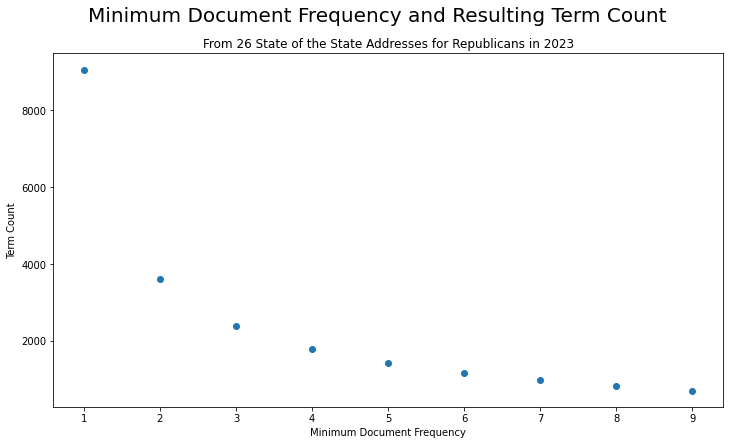

In [155]:
get_min_doc_image(rep, 'Republicans')

##### PCA - Republicans

In [156]:
# not very meaningful or interpretable 
print_pca(rep, 4)

First 5 PC explain 0.2764 of variance in full dataset
First 10 PC explain 0.4968 of variance in full dataset


("PC1: 0.0674 -- ['energy', 'fire', 'power', 'meant', 'enact', 'carbon', 'security', 'innovation', 'produced', 'industries', 'advanced', 'oil', 'mandates', 'land', 'principles', 'fear', 'inflation', 'die', 'national security', 'mind']",
 '',
 "PC2: 0.0575 -- ['energy', 'carbon', 'industries', 'oil', 'innovation', 'advanced', 'security', 'financial', 'agriculture', 'federal', 'winter', 'youth', 'resiliency', 'private', 'markets', 'areas', 'industry', 'proposed', 'grit', 'federal government']",
 '',
 "PC3: 0.0535 -- ['property', 'property tax', 'property taxes', 'relief', 'taxes', 'recommending', 'tax relief', 'percent', 'kids', 'cuts', 'fentanyl', 'tax cuts', 'border', 'michael', 'investments', 'investment', 'local', 'dollar', 'school districts', 'districts']",
 '',
 "PC4: 0.0499 -- ['grid', 'fire', 'border', 'criminals', 'general', 'strong', 'pioneers', 'illegal', 'general assembly', 'schools', 'owners', 'assembly', 'generation', 'pathways', 'hardworking', 'deserve', 'order', 'public s

#### Democrats

In [157]:
# use dtf4 - most interpretable from full ds
dem_dtm4 = tfidf_vectorizer4.fit_transform(dem.text)
dem_dtm4.shape # (24, 1202)

(24, 1202)

In [158]:
# isolate the most frequent terms 
dem_top_terms = get_top_terms(dem_dtm4, tfidf_vectorizer4, 20)  
dem_top_terms

# convert to df
dem_df4 = convert_to_term_df(dem_dtm4, tfidf_vectorizer4)
dem_df4.head() 

array(['housing', 'tax', 'water', 'funding', 'plan', 'nation',
       'investments', 'mental', 'local', 'workforce', 'kids', 'county',
       'program', 'services', 'legislature', 'costs', 'crisis', 'hard',
       'mental health', 'billion'], dtype=object)

,ability,able,abortion,access,accessible,accomplish,achieve,across country,act,action,...,write,years ago,years ahead,years come,yet,young,young people,youth,zero,zoning
0,0.000000,0.000000,0.018422,0.024503,0.000000,0.00000,0.026641,0.00000,0.076626,0.051084,...,0.02185,0.000000,0.043701,0.02185,0.000000,0.013903,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.041631,0.055374,0.000000,0.04938,0.000000,0.04392,0.028862,0.000000,...,0.00000,0.057723,0.000000,0.00000,0.079121,0.000000,0.000000,0.000000,0.000000,0.049380
2,0.021693,0.008615,0.000000,0.068320,0.000000,0.00000,0.008254,0.00000,0.047479,0.039566,...,0.00000,0.015826,0.013539,0.00000,0.010847,0.008615,0.000000,0.011414,0.027078,0.013539
3,0.000000,0.000000,0.000000,0.025172,0.042257,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.052480,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.021047,0.016716,0.000000,0.029460,0.000000,0.00000,0.016016,0.00000,0.000000,0.030710,...,0.00000,0.046065,0.026271,0.00000,0.000000,0.033432,0.022149,0.022149,0.000000,0.000000


##### Hyperparameter Tuning

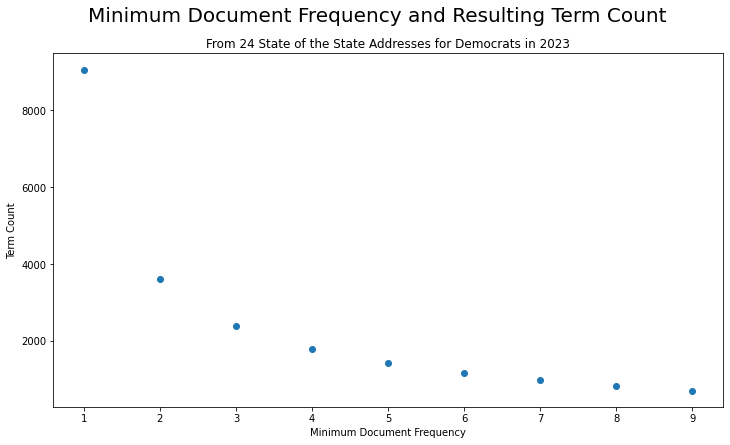

In [159]:
get_min_doc_image(dem, 'Democrats')

##### PCA - Dem

In [160]:
print_pca(dem, 4) # not very interpretative or meaningful 

First 5 PC explain 0.2987 of variance in full dataset
First 10 PC explain 0.5321 of variance in full dataset


("PC1: 0.072 -- ['democracy', 'stories', 'story', 'voices', 'love', 'rights', 'real', 'honor', 'vote', 'oath', 'took', 'came', 'nation', 'serve', 'trying', 'journey', 'father', 'watch', 'stage', 'banning']",
 '',
 "PC2: 0.0676 -- ['housing', 'crisis', 'homelessness', 'legislature', 'idea', 'housing crisis', 'climate', 'units', 'beds', 'listen', 'cost', 'actions', 'homeless', 'within', 'values', 'things', 'affordable', 'difficult', 'hope', 'affordable housing']",
 '',
 "PC3: 0.0539 -- ['creating jobs', 'general assembly', 'assembly', 'county', 'less', 'taxpayers', 'team', 'party', 'rescue', 'growth', 'tax', 'company', 'creating', 'economic growth', 'general', 'fiscal', 'announced', 'worry', 'serving', 'along']",
 '',
 "PC4: 0.0531 -- ['fiscal', 'taxpayers', 'costs', 'less', 'starting', 'growth', 'senator', 'worry', 'easier', 'labor', 'control', 'party', 'election', 'economic growth', 'citizen', 'assistance', 'plan', 'covid', 'rescue', 'room']",
 '',
 "PC5: 0.0521 -- ['costs', 'water', '

#### Compare Top Terms
Since the Principal Components for each party were not very interpretable, let's examine the most frequent terms for each instead.

In [161]:
# print shared top terms 
print('BOTH')
[i for i in dem_top_terms if i in rep_top_terms]

# note: both also focus on taxes based on the individual print outs below (D - 'tax' and R - 'taxes')

BOTH


['workforce', 'kids', 'program', 'legislature']

In [162]:
# print unique top terms for Democrats 
print('DEMOCRATS')
[i for i in dem_top_terms if i not in rep_top_terms]

# housing, mental health, and water are most directly related to policy priorities 

DEMOCRATS


['housing',
 'tax',
 'water',
 'funding',
 'plan',
 'nation',
 'investments',
 'mental',
 'local',
 'county',
 'services',
 'costs',
 'crisis',
 'hard',
 'mental health',
 'billion']

In [163]:
# print unique top terms for Republicans
print('REPUBLICANS')
[i for i in rep_top_terms if i not in dem_top_terms] 

# schools, teacher/s, energy, and property (particularly when considering the PCA results above) are most relevant
# terms related to policy priorities 

REPUBLICANS


['schools',
 'energy',
 'teachers',
 'system',
 'investment',
 'general',
 'needs',
 'percent',
 'property',
 'taxes',
 'session',
 'teacher',
 'fund',
 'community',
 'may',
 'made']